## CO2 Limit

In [266]:
import pypsa
import pandas as pd

In [268]:
prefix = "/mnt/c/Users/scl38887/Documents/git/aldehyde"

# Import from pypsa-earth-sec
run = "wacc15_hem_1marg_1cap_nosmr_0exp_3h_ws"
Co2Ls = ["Co2L20.0", "Co2L5.0", "Co2L2.0", "Co2L1.7", "Co2L1.2", "Co2L1.0", "Co2L0.50", "Co2L0.10"] 

carbon_stats = pd.DataFrame(columns=["constraint", "store", "generators", "loads", "CO2seq", "links"])

for Co2L in Co2Ls:
    n = pypsa.Network(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/elec_s_10_ec_lc1.0_"+Co2L+"_3H_2030_0.15_DF_0export.nc")
    carbon_stats.loc[Co2L, "constraint"] = n.global_constraints.loc["CO2Limit", "constant"] / 1e6 # MtCO2

    carbon_stats.loc[Co2L, "store"] = n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0] / 1e6 # MtCO2
    
    emissions_generator = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h
    carbon_stats.loc[Co2L, "generators"] = n.snapshot_weightings.generators @ emissions_generator.sum(axis=1).div(1e6) # MtCO2

    carbon_stats.loc[Co2L, "loads"] = n.loads[n.loads.bus == "co2 atmosphere"].p_set.sum() * (-1) * 8760/1e6 # MtCO2

    carbon_stats.loc[Co2L, "CO2seq"]=n.stores[n.stores.carrier == "co2 stored"].e_nom_opt.sum() * (-1) / 1e6 # in MtCO2

    links2= (n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index] * n.links.efficiency2[n.links[n.links.bus2 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    links3= (n.links_t.p0[n.links[n.links.bus3 == "co2 atmosphere"].index] * n.links.efficiency3[n.links[n.links.bus3 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    links4= (n.links_t.p0[n.links[n.links.bus4 == "co2 atmosphere"].index] * n.links.efficiency4[n.links[n.links.bus4 == "co2 atmosphere"].index]).sum().sum() / 1e6 * n.snapshot_weightings.generators[0] # in Mt

    carbon_stats.loc[Co2L, "links"] = links2 + links3 + links4

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L20.0_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L5.0_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L2.0_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L1.7_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L1.2_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L1.0_3H_2030_0.15_DF_0export.nc has buses

In [269]:
# Multiply the numeric part of the index by 40 and set it as new index
#carbon_stats.index = carbon_stats.index.str[4:].astype(float) * 40

carbon_stats["sto + gen + loads"] = carbon_stats["store"] + carbon_stats["generators"] + carbon_stats["loads"]
carbon_stats["gen + loads + seq"] = carbon_stats["loads"] + carbon_stats["generators"] + carbon_stats["CO2seq"]
carbon_stats["diff"] = carbon_stats["constraint"] - carbon_stats["sto + gen + loads"]
carbon_stats.astype(float).round(2)

,constraint,store,generators,loads,CO2seq,links,sto + gen + loads,gen + loads + seq,diff
Co2L20.0,800.0,19.04,53.17,17.98,-0.00,1.05,90.19,71.15,709.81
Co2L5.0,200.0,19.04,53.17,17.98,-0.00,1.05,90.19,71.15,109.81
Co2L2.0,80.0,18.98,42.89,17.98,-0.00,1.00,79.86,60.87,0.14
Co2L1.7,68.0,18.96,30.92,17.98,-0.00,0.97,67.86,48.90,0.14
Co2L1.2,48.0,18.64,11.23,17.98,-0.00,0.66,47.86,29.22,0.14
Co2L1.0,40.0,17.97,3.90,17.98,-0.01,-0.01,39.86,21.87,0.14
Co2L0.50,20.0,0.71,1.24,17.98,-17.19,-6.61,19.93,2.03,0.07
Co2L0.10,4.0,-15.19,1.11,17.98,-33.13,-11.51,3.90,-14.04,0.10


In [270]:
carbon_stats["store"] - carbon_stats["loads"] + abs(carbon_stats["CO2seq"])

Co2L20.0    1.052412
Co2L5.0      1.05251
Co2L2.0     1.000964
Co2L1.7     0.973574
Co2L1.2     0.656425
Co2L1.0     0.003233
Co2L0.50   -0.078146
Co2L0.10   -0.042265
dtype: object

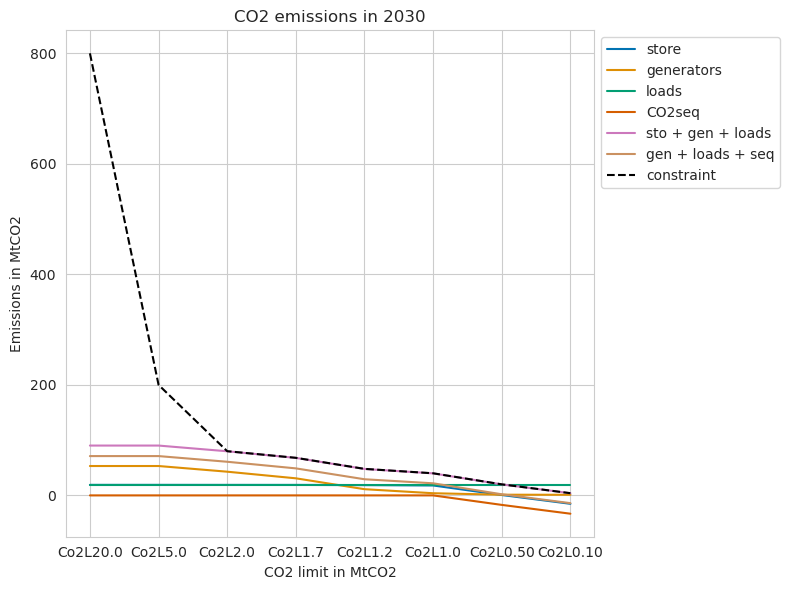

In [277]:
# Plot the carbon stats
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
carbon_stats[["store", "generators", "loads", "CO2seq","sto + gen + loads", "gen + loads + seq"]].iloc[1:,:].plot(ax=ax) 
carbon_stats["constraint"].iloc[1:].plot(ax=ax, style="k--", label="constraint")
ax.set_ylabel("Emissions in MtCO2")
ax.set_xlabel("CO2 limit in MtCO2")
ax.set_title("CO2 emissions in 2030")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

/home/energyls/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1594: UserWarning:

Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.



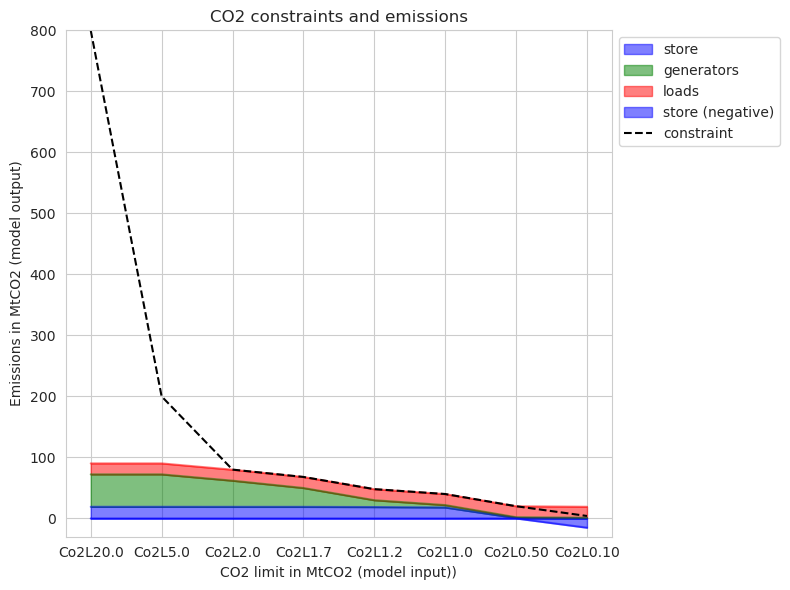

In [286]:
# Plot the carbon stats
import matplotlib.pyplot as plt

start_value = 0

# Create a stackplot + lineplot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot positive 'store' values together with 'generators' and 'loads'
positive_store = carbon_stats["store"].clip(lower=0).iloc[start_value:]
stacked_data = pd.concat([positive_store, carbon_stats[["generators", "loads"]].iloc[start_value:,:]], axis=1)
stacked_data.plot.area(ax=ax, stacked=True, color=["b", "g", "r"], alpha = 0.5, label=["store (positive)", "generators", "loads"])

# Plot negative 'store' values separately
negative_store = carbon_stats["store"].clip(upper=0).iloc[start_value:]
negative_store.plot.area(ax=ax, stacked=True, color="b", alpha = 0.5, label="store (negative)")

# Plot the constraint
carbon_stats["constraint"].iloc[start_value:].plot(ax=ax, style="k--", label="constraint")

ax.set_ylabel("Emissions in MtCO2 (model output)")
ax.set_xlabel("CO2 limit in MtCO2 (model input))")
ax.set_title("CO2 constraints and emissions")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

ax.set_ylim(-30, 800)

fig.tight_layout()
plt.show()


ValueError: When stacked is True, each column must be either all positive or all negative. Column 'store' contains both positive and negative values

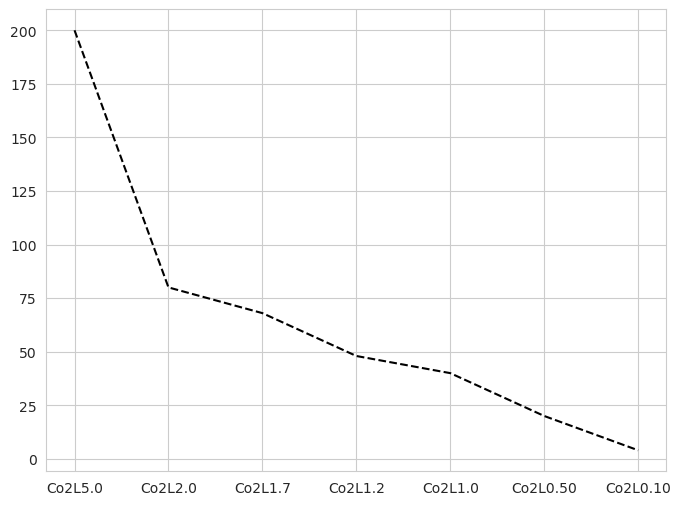

In [220]:
# Plot the carbon stats
import matplotlib.pyplot as plt

# Create a stackplot + lineplot
fig, ax = plt.subplots(figsize=(8, 6))
carbon_stats["constraint"].iloc[1:].plot(ax=ax, style="k--", label="constraint")
carbon_stats[["store", "generators", "loads"]].iloc[1:,:].plot.area(ax=ax, stacked=True)
# Add carbon_stats["store"] to the stackplot
#carbon_stats[["store"]].clip(upper=0).iloc[1:,:].plot.area(ax=ax, stacked=False)


ax.set_ylabel("MtCO2")
ax.set_xlabel("CO2 limit")
ax.set_title("CO2 emissions in 2030")
#ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
fig.tight_layout()

### Ideas
- Instead of catching the emissions through the "store", is it possible to multiply carrier usage with their co2 intensity and sum it up?

### Investigate
- Check, wether the CO2 constraint on the carriers actually applies to the carriers by quantifying the carrier usage multiplied with their co2 intensity and summing it up
- Possible mistake: the carrier "land transport oil" is not listed in n.carriers but used for land transport. It's emissions are accounted in the `co2 atmosphere` store -> (Same as pypsa-eur!). But if there is no "land transport oil" carrier, how does the co2 constraint apply to it?
- Why is gas/OCGT modelled as a link (as well as a generator)?
- co2_absorptions is listed as carrier in pypsa-eur

### Explaination

General
-  There is urban central solid biomass CHP CC, which captures the CO2. Does it make sense that is the same side as DAC in `balances-co2_stored` ?
- PyPSA-Eur has "EU oil" generator, PyPSA-Earth-Sec does not

PyPSA-Eur implementation
- In `prepare_network.py` the function `add_co2limit()` is implemented (-> is this rule called also in the sector coupled version?)
- In `prepare_sector_network.py` the function `add_co2limit()` is implemented (adds the limit either from carbon budget or wildcard). 

PyPSA-Earth-Sec implementaion
- bla

PyPSA-Earth implementation
- The CO2 constraint is set on the carrier (on the carrier attribute "co2_emissions")
- The value in `n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]` is equivalent to "co2" in the graph `balances-co2.pdf`. If the value is negative, it is displayed as positive in the graph
- The value in `n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]` does not include electricity/generation emissions and oil emissions modelled as "loads"
- Through biogas upgrading, it removes co2emissions from the atmosphere (not in reality, but as a balance)
- The CO2 emission factors of the carriers are implemented correctly
- See here: [prepare_network.py](https://github.com/pypsa-meets-earth/pypsa-earth/blob/aab4d18542466e3ffd89cf5af19f5be99aabdf6a/scripts/prepare_network.py#LL74C1-L81C6): 
    ```python
    def add_co2limit(n, annual_emissions, Nyears=1.0):
        n.add(
            "GlobalConstraint",
            "CO2Limit",
            carrier_attribute="co2_emissions",
            sense="<=",
            constant=annual_emissions * Nyears,
        )
    ```

Check CHP usage

In [17]:
n.statistics().loc["Link"][n.statistics().loc["Link"].index.str.contains("CHP")].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
urban central gas CHP,0.21,9.638454e+04,NaN,0.0,1.96,2.23,10.27,0.19,-0.47
urban central gas CHP CC,0.70,1.492987e+09,NaN,0.0,30735.90,10449.29,139595.17,2847.34,-7300.87


Check Biogas usage

In [30]:
n.statistics().loc["Link"][n.statistics().loc["Link"].index.str.contains("bio")].round(2)

,Capacity Factor,Capital Expenditure,Curtailment,Installed Capacity,Operational Expenditure,Optimal Capacity,Revenue,Supply,Withdrawal
carrier,,,,,,,,,
biogas to gas,1.00,5.525198e+08,NaN,0.0,23607.61,7402.03,-283205.71,7401.13,-7401.13
biomass EOP,0.41,1.403531e+05,NaN,0.0,0.20,0.77,18.84,0.09,-0.31
solid biomass for industry,inf,0.000000e+00,NaN,0.0,-0.00,0.00,0.00,0.00,-0.00
solid biomass for industry CC,0.00,3.009100e+03,NaN,0.0,0.00,0.02,-0.00,0.00,-0.00
solid biomass transport,0.00,1.992530e+05,NaN,0.0,29.62,25176.53,0.00,4.63,-4.63


Show graph in Markdown
<image src="/mnt/c/Users/scl38887/Documents/git/aldehyde/workflow/subworkflows/pypsa-earth-sec/results/wacc15_hem_1marg_1cap_nosmr_0exp_3h_ws/graphs/balances-AC.pdf" />

Show graph in Markdown
<image src="/mnt/c/Users/scl38887/Documents/git/aldehyde/workflow/subworkflows/pypsa-earth-sec/results/wacc15_hem_1marg_1cap_nosmr_0exp_3h_ws/graphs/balances-DC.pdf" />

In [18]:
n.global_constraints.loc["CO2Limit"].constant

68000000.0

Check CO2 stores

In [38]:
n.stores[n.stores.index.str.contains("co2 atmosphere")]

,bus,capital_cost,carrier,e_cyclic,e_initial,e_min_pu,e_nom,e_nom_extendable,lifetime,marginal_cost,...,type,e_nom_min,e_nom_max,e_max_pu,e_initial_per_period,e_cyclic_per_period,p_set,q_set,sign,build_year
Store,,,,,,,,,,,,,,,,,,,,,
co2 atmosphere,co2 atmosphere,0.0,co2,False,0.0,-1.0,0.0,True,inf,0.00992,...,,0.0,inf,1.0,False,True,0.0,0.0,1.0,0


In [50]:
n.stores_t.e["co2 atmosphere"][-1]/1e6 # MtCO2
# equivalent to n.stores_t.e.filter(like="co2 atmosphere").iloc[-1][0]/ 1e6 # MtCO2
# equivalent to (n.stores_t.p["co2 atmosphere"]*n.snapshot_weightings.generators[0]).sum()/1e6 # MtCO2

-15.191386448535619

In [29]:
# Plot the store
#n.stores_t.e.filter(like="co2 atmosphere").plot()

CO2 sequestration

In [93]:
n.stores[n.stores.carrier == "co2 stored"].e_nom_opt.sum() / 1e6 # in MtCO2

33.133126337551836

Check CO2 balances: links, generators, stores, loads

In [112]:
# Show all input and outputs of the bus "co2 atmosphere"
n.links[n.links.bus2 == "co2 atmosphere"].carrier.unique()

array(['OCGT', 'biomass EOP', 'biogas to gas',
       'residential rural gas boiler', 'services rural gas boiler',
       'residential urban decentral gas boiler',
       'services urban decentral gas boiler', 'urban central gas boiler',
       'solid biomass for industry CC', 'gas for industry',
       'gas for industry CC'], dtype=object)

In [144]:
n.links.bus3.str.contains("co2 atmosphere").any()

True

In [152]:
# Show timeseries of all links connected to "co2 atmosphere"
n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index].sum(axis=1).sum() / 1e6 # in TWH (?)

21.905562173742357

In [187]:
test = (n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index] * n.links.efficiency2[n.links[n.links.bus2 == "co2 atmosphere"].index]).sum().sort_values() * n.snapshot_weightings.generators[0] / 1e6 #.sum().sum() / 1e6 # in Mt

In [189]:
test[test != 0]

Link
MA.12.3_1_AC biogas to gas                           -2.986766
MA.9.2_1_AC biogas to gas                            -2.576405
MA.12.4_1_AC biogas to gas                           -2.533285
MA.12.5_1_AC biogas to gas                           -1.769921
MA.8.3_1_AC biogas to gas                            -0.227011
                                                        ...   
MA.2.2_1_AC residential urban decentral gas boiler    0.007516
MA.4.1_1_AC residential urban decentral gas boiler    0.010109
MA.5.2_1_AC residential urban decentral gas boiler    0.010672
MA.1.3_1_AC residential urban decentral gas boiler    0.011062
MA.5.1_1_AC residential urban decentral gas boiler    0.011432
Length: 370, dtype: float64

In [186]:
test[50:70]

Link
MA.12.6_1_AC solid biomass for industry CC    0.0
MA.12.5_1_AC solid biomass for industry CC    0.0
MA.13.1_1_AC solid biomass for industry CC    0.0
MA.12.4_1_AC solid biomass for industry CC    0.0
MA.1.3_1_AC solid biomass for industry CC     0.0
MA.12.1_1_AC solid biomass for industry CC    0.0
MA.12.2_1_AC solid biomass for industry CC    0.0
MA.10.1_1_AC solid biomass for industry CC    0.0
MA.9.4_1_AC gas for industry CC               0.0
MA.10.3_1_AC solid biomass for industry CC    0.0
MA.10.4_1_AC solid biomass for industry CC    0.0
MA.11.4_1_AC solid biomass for industry CC    0.0
MA.10.5_1_AC solid biomass for industry CC    0.0
MA.11.1_1_AC solid biomass for industry CC    0.0
MA.11.3_1_AC solid biomass for industry CC    0.0
MA.12.3_1_AC solid biomass for industry CC    0.0
MA.14.1_1_AC solid biomass for industry CC    0.0
MA.14.2_1_AC gas for industry                 0.0
MA.13.2_1_AC solid biomass for industry CC    0.0
MA.8.5_1_AC solid biomass for industry CC    

In [ ]:
links2= (n.links_t.p0[n.links[n.links.bus2 == "co2 atmosphere"].index] * n.links.efficiency2[n.links[n.links.bus2 == "co2 atmosphere"].index]).sum().sum() / 1e6 # in Mt

-4.263253032513284

In [169]:
links3 = (n.links_t.p0[n.links[n.links.bus3 == "co2 atmosphere"].index] * n.links.efficiency3[n.links[n.links.bus3 == "co2 atmosphere"].index]).sum().sum() / 1e6 # in Mt

0.4266422001987908

In [170]:
links4 = (n.links_t.p0[n.links[n.links.bus4 == "co2 atmosphere"].index] * n.links.efficiency4[n.links[n.links.bus4 == "co2 atmosphere"].index]).sum().sum() / 1e6 # in Mt

0.0

In [117]:
# Of course no generator feed in into co2 atmosphere
n.generators[n.generators.bus == "co2 atmosphere"].carrier.unique()

array([], dtype=object)

In [ ]:

# Lets see the stores
n.stores[n.stores.index.str.contains("co2 atmosphere")]

In [76]:
n.loads[n.loads.bus == "co2 atmosphere"]

,bus,carrier,p_set,type,q_set,sign
Load,,,,,,
industry oil emissions,co2 atmosphere,industry oil emissions,-0.000000,,0.0,-1.0
shipping oil emissions,co2 atmosphere,shipping oil emissions,-311.795205,,0.0,-1.0
aviation oil emissions,co2 atmosphere,oil emissions,-267.740223,,0.0,-1.0
land transport oil emissions,co2 atmosphere,land transport oil emissions,-1473.433121,,0.0,-1.0


In [ ]:
n.loads[n.loads.bus == "co2 atmosphere"].p_set.sum() * 8760/1e6 # MtCO2

-17.984004494442807

In [102]:
n.loads[n.loads.bus == "process emissions"].p_set.sum() * 8760/1e6 # MtCO2

0.0

Check carriers (relevant for the constraint)

In [30]:
n.carriers #.index.str.contains("oil")

,co2_emissions,color,nice_name,max_growth,max_relative_growth
Carrier,,,,,
lignite,0.41,#9e5a01,Lignite,inf,0.0
biomass,0.00,#0c6013,Biomass,inf,0.0
geothermal,0.03,#ba91b1,Geothermal,inf,0.0
CCGT,0.20,#b20101,Combined-Cycle Gas,inf,0.0
solar,0.00,#f9d002,Solar,inf,0.0
onwind,0.00,#235ebc,Onshore Wind,inf,0.0
oil,0.26,#262626,Oil,inf,0.0
coal,0.34,#707070,Coal,inf,0.0
offwind-ac,0.00,#6895dd,Offshore Wind (AC),inf,0.0


Check PyPSA-Eur for comparison

In [10]:
# Check carriers of pypsa-eur
n_eur = pypsa.Network("/mnt/c/Users/scl38887/Documents/git/pypsa-eur/results/testrun/postnetworks/elec_s_37_lv1.0__Co2L0-2000H-T-H-B-I-A-solar+p3-dist1_2050.nc")
#n_eur.carriers.index.str.contains("oil")
n_eur.generators.carrier.unique()

INFO:pypsa.io:Imported network elec_s_37_lv1.0__Co2L0-2000H-T-H-B-I-A-solar+p3-dist1_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


array(['offwind-ac', 'onwind', 'ror', 'solar', 'offwind-dc', 'gas',
       'residential rural solar thermal', 'services rural solar thermal',
       'residential urban decentral solar thermal',
       'services urban decentral solar thermal',
       'urban central solar thermal', 'oil', 'solar rooftop'],
      dtype=object)

In [37]:
n.generators[n.generators.carrier == "oil"]   

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
MA.12.6_1_AC oil,inf,0.0,211.386221,61499.694996,0.35,211.386221,148.868076,MA.12.6_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.14.5_1_AC oil,inf,0.0,134.318647,61499.694996,0.35,134.318647,148.867075,MA.14.5_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.4.1_1_AC oil,inf,0.0,277.900649,61499.694996,0.35,277.900649,148.867387,MA.4.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.1_1_AC oil,inf,0.0,188.972441,61499.694996,0.35,188.972441,148.866741,MA.5.1_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
MA.5.2_1_AC oil,inf,0.0,925.409160,61499.694996,0.35,925.409160,148.866508,MA.5.2_1_AC,oil,False,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [ ]:
n_eur.generators[n_eur.generators.carrier == "oil"]

In [11]:
n_eur.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
lv_limit,transmission_volume_expansion_limit,"AC, DC",<=,1.511434e+08,NaN,0.0
CO2Limit,primary_energy,co2_emissions,<=,0.000000e+00,NaN,0.0
co2_sequestration_limit,primary_energy,co2_absorptions,<=,2.000000e+08,NaN,0.0


In [14]:
n.global_constraints

,type,carrier_attribute,sense,constant,investment_period,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,co2_emissions,<=,4.000000e+06,NaN,0.0
lc_limit,transmission_expansion_cost_limit,"AC, DC",<=,9.838156e+08,NaN,0.0


Compute actual CO2 emissions (using the carriers)

Next: Include links (e.g. oil)? 
- Alternative Approach: Connect AC generators to CO2 atmosphere bus? -> modelled as links
- -> Check how pypsa-eur does it!

In [154]:
carrier = "coal"
total_usage = 0.0

# Iterate over the generators
for _, gen in n_highem.generators.iterrows():
    total_usage += n_highem.generators_t.p[gen.name].sum() * n.snapshot_weightings.generators[0] if gen.carrier.upper() == carrier.upper() else 0.0

# Iterate over the links
for _, link in n_highem.links.iterrows():
    total_usage += n_highem.links_t.p0[link.name].sum() * n.snapshot_weightings.links[0] if link.carrier.upper() == carrier.upper() else 0.0
    


print(f"Total {carrier} usage: {total_usage/1e3:.2f} GWh")


Total coal usage: 50061.46 GWh


In [21]:
# Read high emission network (Co2L = 20.0)
Co2L = "Co2L20.0"
n_highem = pypsa.Network(prefix + "/workflow/subworkflows/pypsa-earth-sec/results/" + run + "/postnetworks/elec_s_10_ec_lc1.0_"+Co2L+"_3H_2030_0.15_DF_0export.nc")

INFO:pypsa.io:Imported network elec_s_10_ec_lc1.0_Co2L20.0_3H_2030_0.15_DF_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [22]:
emissions = n_highem.generators_t.p / n_highem.generators.efficiency * n_highem.generators.carrier.map(n_highem.carriers.co2_emissions) # t/h

In [23]:
n_highem.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

53.16724895696999

In [123]:
n.loads.carrier.unique()    

array(['AC', 'residential rural heat', 'services rural heat',
       'residential urban decentral heat',
       'services urban decentral heat', 'urban central heat',
       'solid biomass for industry', 'gas for industry',
       'H2 for industry', 'naphtha for industry',
       'industry oil emissions', 'low-temperature heat for industry',
       'industry electricity', 'process emissions', 'H2 for shipping',
       'shipping oil', 'shipping oil emissions', 'kerosene for aviation',
       'oil emissions', 'land transport EV', 'land transport fuel cell',
       'land transport oil', 'land transport oil emissions', 'H2'],
      dtype=object)

In [70]:
n.generators_t.p[gen.name].sum() * n.snapshot_weightings.generators[0]

18.301555418878717

In [113]:
# Links connected to the co2 atmosphere. OCGT/ Gas is added here: https://github.com/PyPSA/pypsa-eur/blob/master/scripts/prepare_sector_network.py#L767
n.links[n.links.bus2 == "co2 atmosphere"].carrier.unique() #.bus

array(['OCGT', 'biomass EOP', 'biogas to gas',
       'residential rural gas boiler', 'services rural gas boiler',
       'residential urban decentral gas boiler',
       'services urban decentral gas boiler', 'urban central gas boiler',
       'solid biomass for industry CC', 'gas for industry',
       'gas for industry CC'], dtype=object)

### Old stuff

In [ ]:
# Get the energy of all generators grouped by carrier
n.generators_t.p.groupby(n.generators.carrier,axis=1).sum().sum()/1e6*n.snapshot_weightings.generators[0] #in TWh

In [ ]:
#n.generators.p_nom_opt.groupby(n.generators.carrier).sum()/1e3

In [ ]:
# Get the energy of all loads grouped by carrier using the snapshot_weightings and loads_t.p_set
n.loads_t.p.groupby(n.loads.carrier,axis=1).sum().sum()/1e6*n.snapshot_weightings.generators[0] #in TWh

In [ ]:
# Total capacity Fischer-Tropsch    
n.links[n.links.carrier.str.contains('Fischer-Tropsch')].p_nom_opt.sum() /1e3 # in GW

In [ ]:
# Get the energy of Fischer tropsch
n.links_t.p0[n.links[n.links.carrier.str.contains('Fischer-Tropsch')].index].sum().sum()*n.snapshot_weightings.generators[0]/1e6 # in TWh

In [ ]:
n.buses_t.p

In [ ]:
n.buses_t.p[n.buses.carrier.str.contains('oil')]